# XGBoost Forecasting

In [ ]:
import pandas as pd
import numpy as np
import joblib
import hashlib
import tensorflow as tf
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,IsolationForest
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost.sklearn import XGBRegressor,XGBClassifier
from xgboost import plot_importance, plot_tree

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle
import warnings
warnings.filterwarnings("ignore")

# Data Load

In [40]:
model_df1 = pd.read_csv('final_data_whole.csv',index_col=0)



# Column Selection

In [41]:
allColumns = ['Flight_No','org','dst','SCH_DEP_DATE','BKD_WT_sum','BKD_VOL_sum','CHG_WT_BU_sum','INHOUSE_AC_TYP','OPN_MODE','SVC_TYP','AC_CGO_WT_BU','AC_CGO_VOL_BU','CMRCL_CGO_WT_BU','CMRCL_CGO_VOL_BU','NOOP_CAN_IND','ISO_CODE','EST_CGO_PLOD_WT_BU','EST_CGO_PLOD_VOL_BU','ORG_AIRPORT_CODE','ORG_AIRPORT_NAME','ORG_CNTRY_NAME','ORG_REGION_NAME','DST_AIRPORT_CODE','DST_AIRPORT_NAME','DST_CNTRY_NAME','DST_REGION_NAME','org_hday_flg','dst_hday_flg','EST_CHG_WT']
allcategorical = ['Flight_No','org','dst','SCH_DEP_DATE','INHOUSE_AC_TYP','OPN_MODE','SVC_TYP','ISO_CODE','ORG_AIRPORT_CODE','ORG_AIRPORT_NAME','ORG_CNTRY_NAME','ORG_REGION_NAME','DST_AIRPORT_CODE','DST_AIRPORT_NAME','DST_CNTRY_NAME','DST_REGION_NAME']
allnumerical = ['BKD_WT_sum','BKD_VOL_sum','CHG_WT_BU_sum','AC_CGO_WT_BU','AC_CGO_VOL_BU','CMRCL_CGO_WT_BU','CMRCL_CGO_VOL_BU','NOOP_CAN_IND','EST_CGO_PLOD_WT_BU','EST_CGO_PLOD_VOL_BU','org_hday_flg','dst_hday_flg','EST_CHG_WT']

In [42]:
def dropColumns(df,colm_array):
    df_dropped=df.drop(colm_array, axis = 1)
    return df_dropped;

In [43]:
def selectColumns(df,colm_array):
    df_selected=df[colm_array]
    return df_selected;

In [44]:
model_df=selectColumns(model_df1,allColumns)
model_df.head()

,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg,EST_CHG_WT
0,2999,DCW,NCL,2019-06-02,17269.500,70.514913,17601.000,388R,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,1,21642.097658
1,2999,DCW,NCL,2020-05-21,22639.030,126.371295,25426.330,77WER,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,50070.719657
2,2999,DCW,NCL,2020-07-12,21443.040,95.318517,22224.430,77WEQ,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,34930.000949
3,2999,DCW,NCL,2020-10-21,12198.506,78.929117,14969.203,388T,J,J,...,0,0,0,NCL,International,UNITED KINGDOM,EUROPE,0,0,66747.776549
4,3999,NCL,DCW,2019-02-05,9460.200,45.176032,10310.500,388L,J,J,...,International,UNITED KINGDOM,EUROPE,0,0,0,0,0,0,43592.742441


# Exploratory Data Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

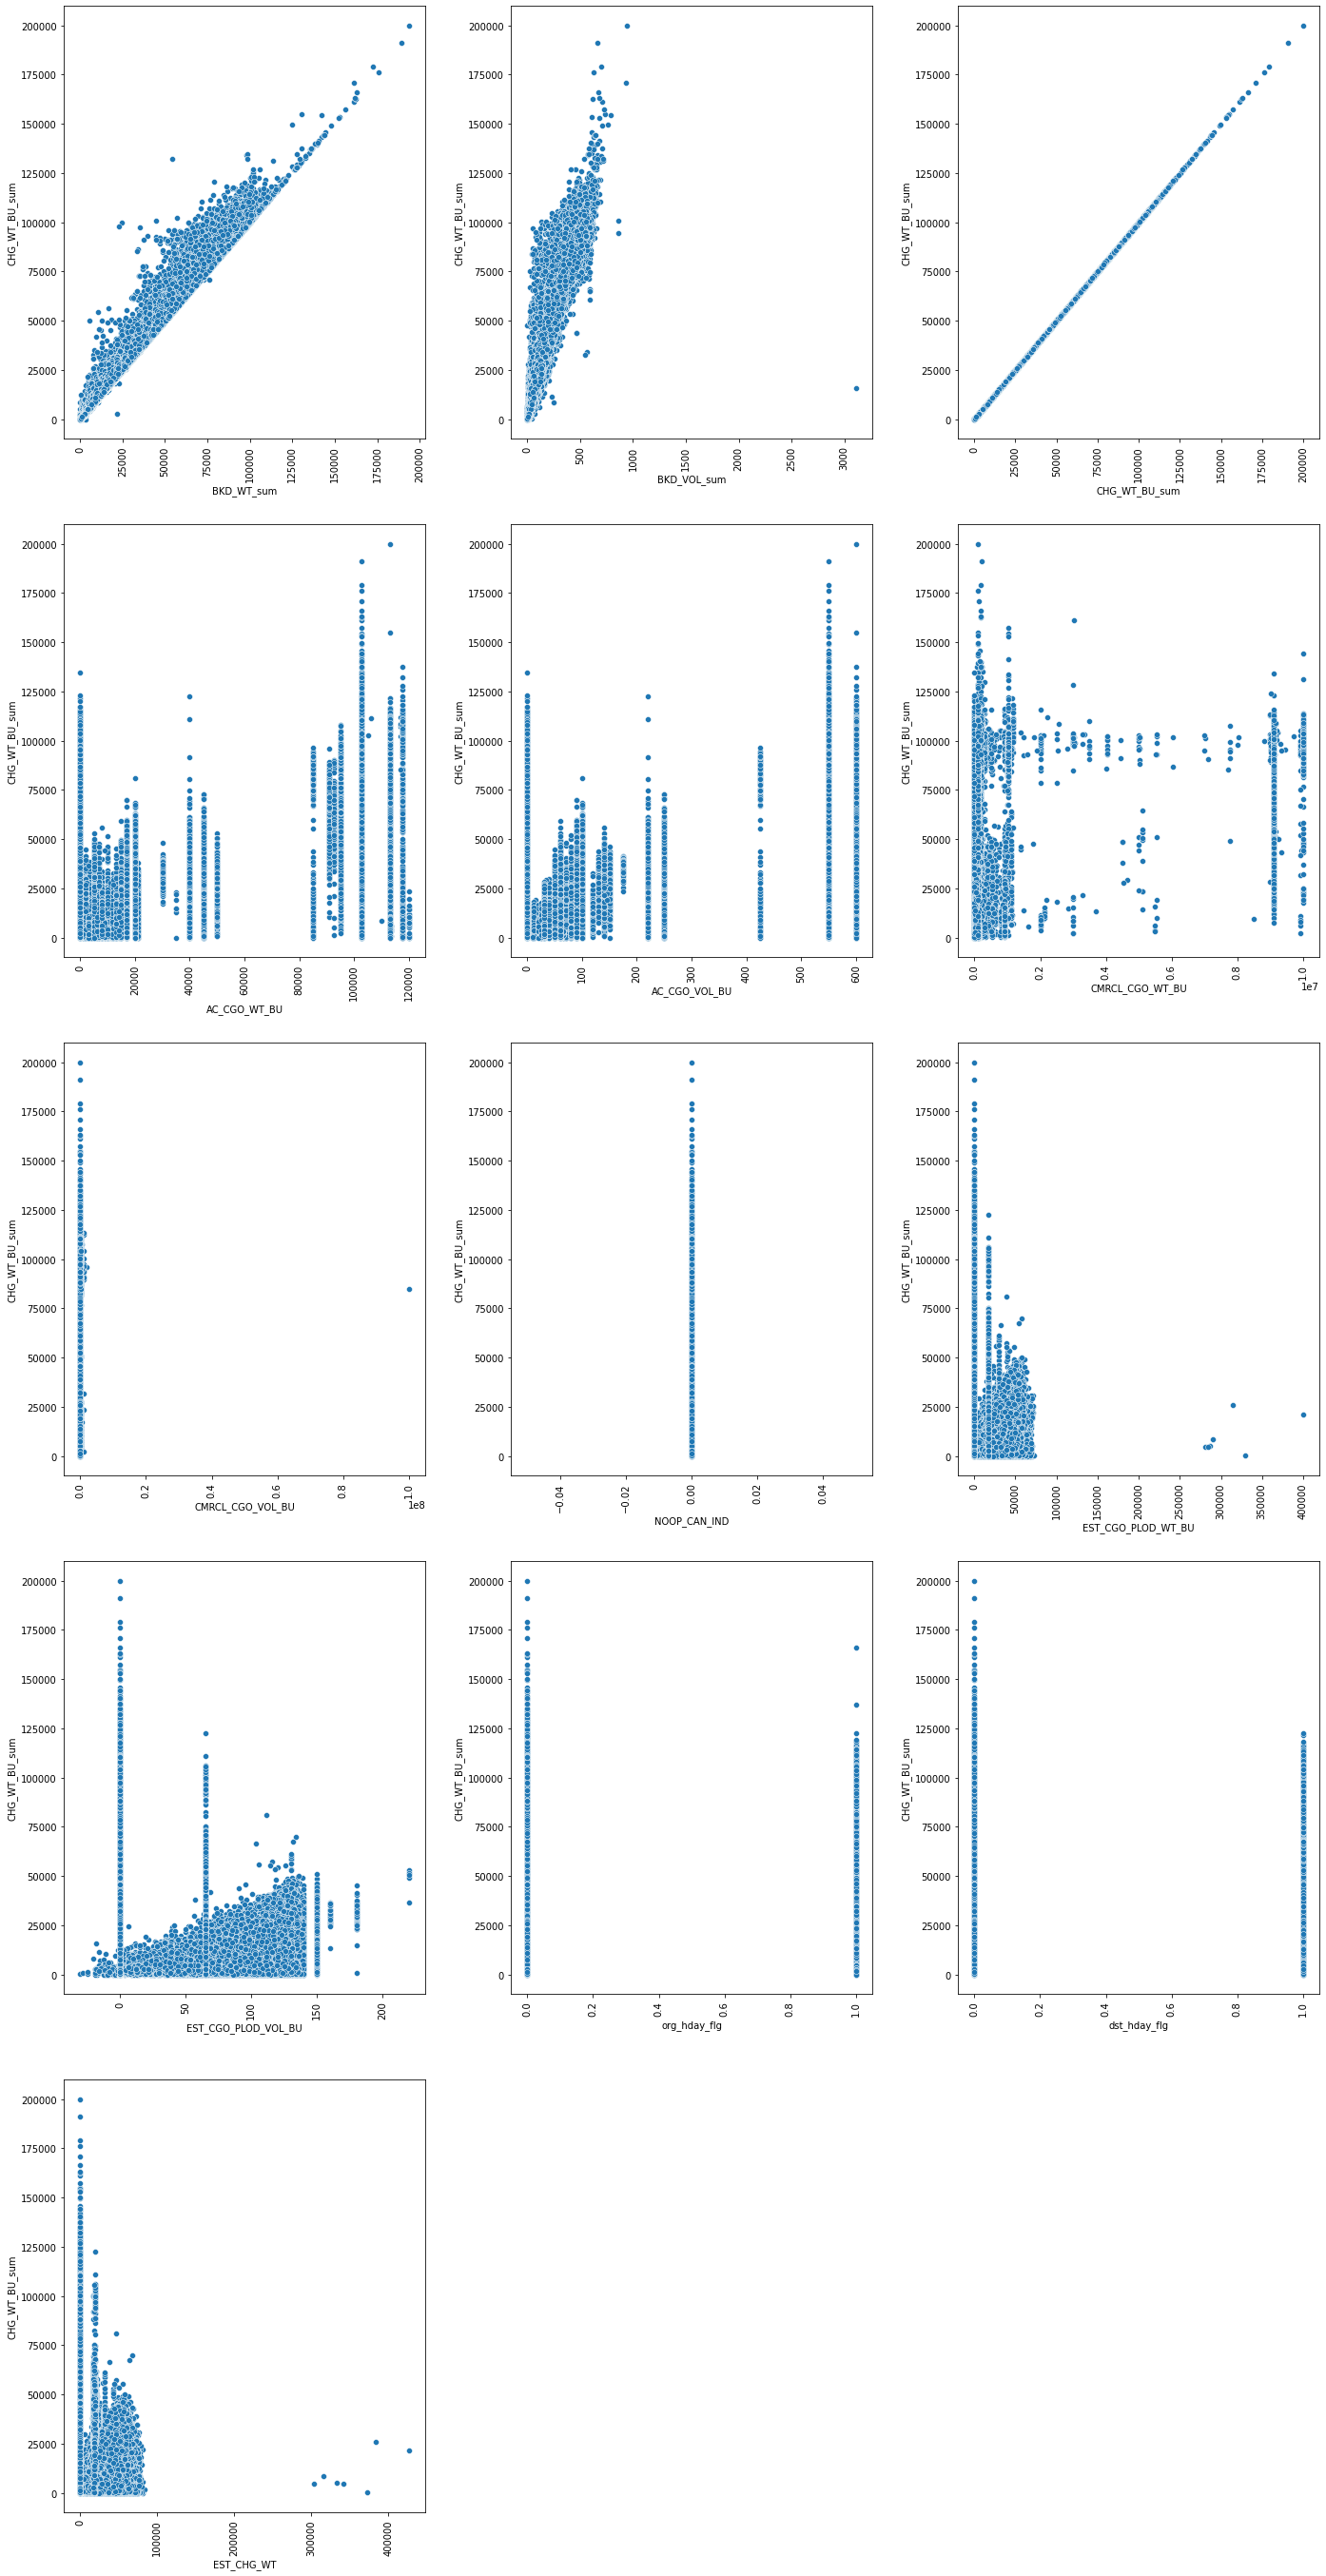

In [45]:
c=1
plt.figure(figsize=(20,45))

for i in allnumerical:
    plt.subplot(6,3,c)
    sns.scatterplot(x=model_df[i],y=model_df.CHG_WT_BU_sum)
    plt.xticks(rotation = 90)
    plt.tight_layout(pad = 3.0)
    c=c+1
plt.show 

# Feature Engineering

In [46]:
model_df=dropColumns(model_df1,['ORG_REGION_NAME','DST_REGION_NAME','ORG_AIRPORT_CODE','ORG_AIRPORT_NAME','ORG_CNTRY_NAME','DST_AIRPORT_CODE','DST_AIRPORT_NAME','DST_CNTRY_NAME'])


In [47]:
model_df['Date'] = pd.to_datetime(model_df['SCH_DEP_DATE']).dt.day
model_df['Month'] = pd.to_datetime(model_df['SCH_DEP_DATE']).dt.month
model_df['SCH_DEP_YEAR'] = pd.to_datetime(model_df['SCH_DEP_DATE']).dt.year
model_df['SCH_DEP_DoW'] = pd.to_datetime(model_df['SCH_DEP_DATE']).dt.dayofweek
model_df['SCH_DEP_WoY'] = pd.to_datetime(model_df['SCH_DEP_DATE']).dt.weekofyear
model_df['SCH_DEP_DoY'] = pd.to_datetime(model_df['SCH_DEP_DATE']).dt.dayofyear
model_df['SCH_DEP_QTR'] = pd.to_datetime(model_df['SCH_DEP_DATE']).dt.quarter
model_df= model_df.sort_values(by='SCH_DEP_DATE',ascending=True)
model_df =model_df.drop(['SCH_DEP_DATE'], axis = 1)
model_df.head(4)



,Flight_No,org,dst,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,AC_CGO_WT_BU,...,org_hday_flg,dst_hday_flg,EST_CHG_WT,Date,Month,SCH_DEP_YEAR,SCH_DEP_DoW,SCH_DEP_WoY,SCH_DEP_DoY,SCH_DEP_QTR
244554,7249,DCW,KIX,6722.0,29.812950,6909.5,388P,J,J,15000.0,...,0,0,34522.966768,31,12,2018,0,1,365,4
192793,2469,PEW,DCW,3543.0,15.899021,3632.0,77WER,J,J,20000.0,...,0,0,24549.821430,31,12,2018,0,1,365,4
55096,98X9,IKA,DCW,9173.0,38.819548,9173.0,77LJ,J,J,13000.0,...,0,0,28309.559019,31,12,2018,0,1,365,4
143616,5849,DCW,KUL,1030.7,7.787627,1294.0,388L,J,J,15000.0,...,0,0,24621.789590,31,12,2018,0,1,365,4


In [48]:
numeric = ['Flight_No','org_hday_flg', 'dst_hday_flg', 'EST_CHG_WT','SCH_DEP_YEAR','SCH_DEP_DoW','SCH_DEP_WoY']


#Label Encoding

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in model_df.columns:
    if  model_df[i].dtypes == 'object':
        print(i)
        model_df[i] = le.fit_transform(model_df[i])

model_df.head(5)


Flight_No
org
dst
INHOUSE_AC_TYP
OPN_MODE
SVC_TYP
ISO_CODE


,Flight_No,org,dst,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,AC_CGO_WT_BU,...,org_hday_flg,dst_hday_flg,EST_CHG_WT,Date,Month,SCH_DEP_YEAR,SCH_DEP_DoW,SCH_DEP_WoY,SCH_DEP_DoY,SCH_DEP_QTR
244554,669,42,99,6722.0,29.812950,6909.5,6,2,6,15000.0,...,0,0,34522.966768,31,12,2018,0,1,365,4
192793,40,130,47,3543.0,15.899021,3632.0,28,2,6,20000.0,...,0,0,24549.821430,31,12,2018,0,1,365,4
55096,1013,78,47,9173.0,38.819548,9173.0,21,2,6,13000.0,...,0,0,28309.559019,31,12,2018,0,1,365,4
143616,484,42,101,1030.7,7.787627,1294.0,5,2,6,15000.0,...,0,0,24621.789590,31,12,2018,0,1,365,4
237682,638,5,47,8520.0,20.000000,8520.0,0,0,0,0.0,...,0,0,0.000000,31,12,2018,0,1,365,4


#Pearson Correlation

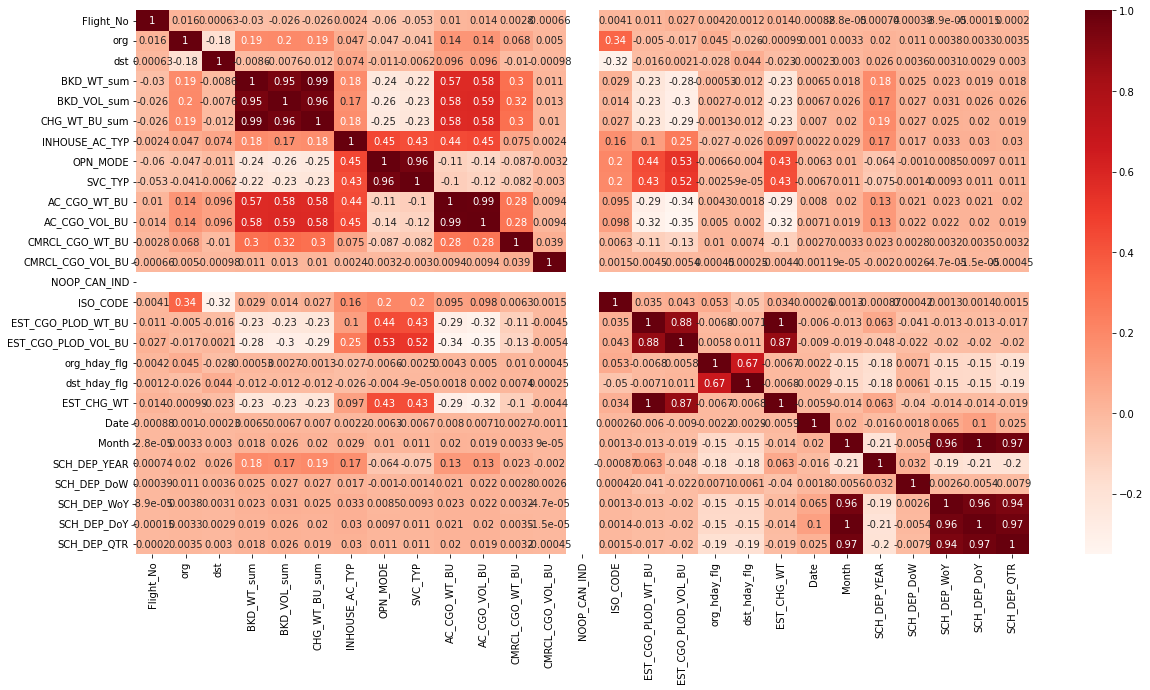

In [50]:
from sklearn.feature_selection import RFE
#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = model_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [51]:
#Correlation with output variable
cor_target = abs(cor["CHG_WT_BU_sum"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.25]
relevant_features

BKD_WT_sum             0.993067
BKD_VOL_sum            0.962217
CHG_WT_BU_sum          1.000000
OPN_MODE               0.250668
AC_CGO_WT_BU           0.577451
AC_CGO_VOL_BU          0.581504
CMRCL_CGO_WT_BU        0.299957
EST_CGO_PLOD_VOL_BU    0.287125
Name: CHG_WT_BU_sum, dtype: float64

In [52]:
print(model_df[["AC_CGO_WT_BU","AC_CGO_VOL_BU"]].corr())
print(model_df[["AC_CGO_WT_BU","CMRCL_CGO_WT_BU"]].corr())
print(model_df[["CMRCL_CGO_WT_BU","EST_CGO_PLOD_VOL_BU"]].corr())
print(model_df[["EST_CHG_WT","EST_CGO_PLOD_WT_BU"]].corr())
print(model_df[["SCH_DEP_DoY","CMRCL_CGO_WT_BU"]].corr())

               AC_CGO_WT_BU  AC_CGO_VOL_BU
AC_CGO_WT_BU       1.000000       0.992668
AC_CGO_VOL_BU      0.992668       1.000000
                 AC_CGO_WT_BU  CMRCL_CGO_WT_BU
AC_CGO_WT_BU         1.000000         0.277305
CMRCL_CGO_WT_BU      0.277305         1.000000
                     CMRCL_CGO_WT_BU  EST_CGO_PLOD_VOL_BU
CMRCL_CGO_WT_BU              1.00000             -0.13243
EST_CGO_PLOD_VOL_BU         -0.13243              1.00000
                    EST_CHG_WT  EST_CGO_PLOD_WT_BU
EST_CHG_WT            1.000000            0.995404
EST_CGO_PLOD_WT_BU    0.995404            1.000000
                 SCH_DEP_DoY  CMRCL_CGO_WT_BU
SCH_DEP_DoY         1.000000         0.003472
CMRCL_CGO_WT_BU     0.003472         1.000000


#Backward Elimination

In [53]:
X = model_df.drop("CHG_WT_BU_sum",1)
X = X.drop(['BKD_WT_sum','BKD_VOL_sum','SCH_DEP_DoY','SCH_DEP_QTR'],1)    #Feature Matrix
y = model_df["CHG_WT_BU_sum"]                 #Target Variable


In [54]:
import statsmodels.api as sm
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y.values.reshape(-1,1),X_1).fit()
model.pvalues

const                   0.000000e+00
Flight_No              5.270834e-256
org                     0.000000e+00
dst                     0.000000e+00
INHOUSE_AC_TYP          6.313095e-39
OPN_MODE                0.000000e+00
SVC_TYP                3.902234e-245
AC_CGO_WT_BU           9.565133e-151
AC_CGO_VOL_BU           2.499573e-60
CMRCL_CGO_WT_BU         0.000000e+00
CMRCL_CGO_VOL_BU        5.794039e-01
NOOP_CAN_IND            0.000000e+00
ISO_CODE               7.972611e-215
EST_CGO_PLOD_WT_BU      9.077197e-20
EST_CGO_PLOD_VOL_BU     1.893695e-18
org_hday_flg            3.385398e-13
dst_hday_flg            2.054199e-04
EST_CHG_WT              5.777422e-15
Date                    1.993768e-01
Month                   1.862769e-02
SCH_DEP_YEAR            0.000000e+00
SCH_DEP_DoW             9.936557e-18
SCH_DEP_WoY             2.535682e-08
dtype: float64

In [55]:
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y.values.reshape(-1,1),X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.0000000005):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['Flight_No', 'org', 'dst', 'INHOUSE_AC_TYP', 'OPN_MODE', 'SVC_TYP', 'AC_CGO_WT_BU', 'AC_CGO_VOL_BU', 'CMRCL_CGO_WT_BU', 'NOOP_CAN_IND', 'ISO_CODE', 'EST_CGO_PLOD_WT_BU', 'EST_CGO_PLOD_VOL_BU', 'org_hday_flg', 'EST_CHG_WT', 'SCH_DEP_YEAR', 'SCH_DEP_DoW', 'SCH_DEP_WoY']


#Embedded Method

In [56]:
from sklearn.linear_model import LassoCV
X=X.drop(['OPN_MODE','SVC_TYP','CMRCL_CGO_VOL_BU','AC_CGO_VOL_BU','EST_CGO_PLOD_VOL_BU','EST_CGO_PLOD_WT_BU','NOOP_CAN_IND','ISO_CODE','Month','Date'], axis = 1)
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 3021257.131695
Best score using built-in LassoCV: 0.357921


In [57]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 3 variables and eliminated the other 9 variables


In [58]:
imp_coef = coef.sort_values()
imp_coef

EST_CHG_WT        -0.053978
Flight_No         -0.000000
org                0.000000
dst               -0.000000
INHOUSE_AC_TYP    -0.000000
org_hday_flg      -0.000000
dst_hday_flg      -0.000000
SCH_DEP_YEAR       0.000000
SCH_DEP_DoW        0.000000
SCH_DEP_WoY        0.000000
CMRCL_CGO_WT_BU    0.004561
AC_CGO_WT_BU       0.409716
dtype: float64

# Outlier Detection and Removal

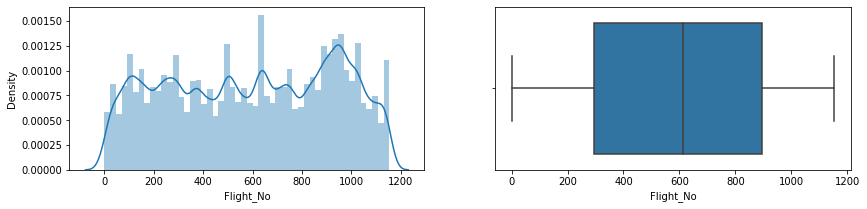

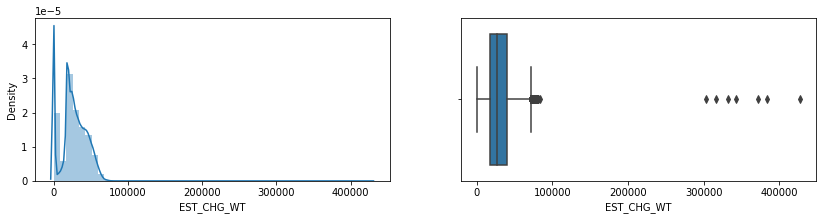

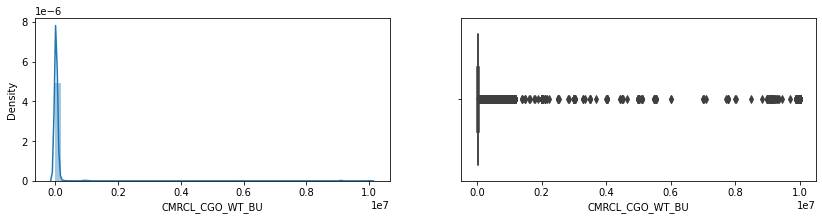

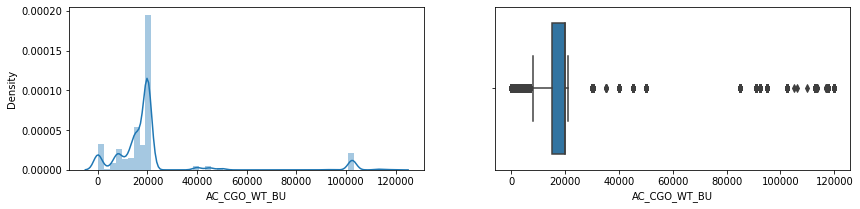

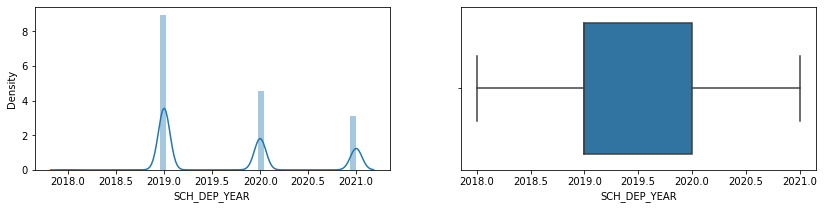

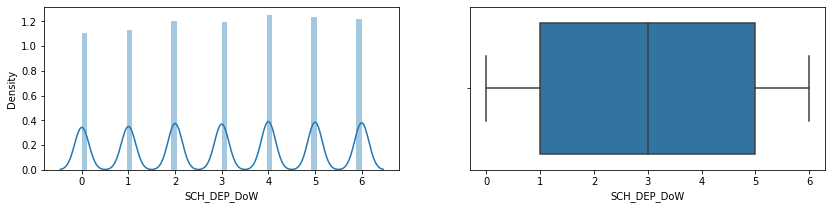

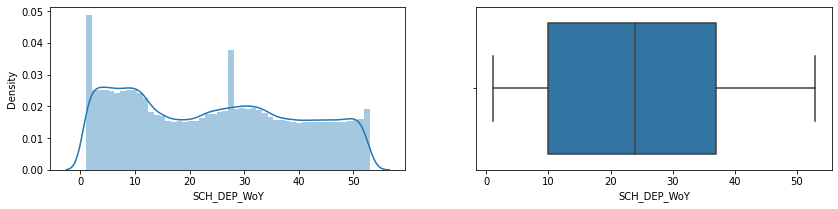

In [59]:
import warnings
warnings.filterwarnings('ignore')
features = ['Flight_No','EST_CHG_WT','CMRCL_CGO_WT_BU','AC_CGO_WT_BU','SCH_DEP_YEAR','SCH_DEP_DoW','SCH_DEP_WoY']
for i in features:
    plt.figure(figsize=(14,3))
    plt.subplot(1,2,1)
    sns.distplot(model_df[i])
    plt.subplot(1,2,2)
    sns.boxplot(model_df[i])

In [60]:
skewed_features = ['EST_CHG_WT','CMRCL_CGO_WT_BU','AC_CGO_WT_BU']
for i in skewed_features:
    percentile25 = model_df[i].quantile(0.25)
    percentile75 = model_df[i].quantile(0.75)
    iqr = percentile75 -percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    model_df[i] = np.where(
    model_df[i] > upper_limit,
    upper_limit,
    np.where(
        model_df[i] < lower_limit,
        lower_limit,
        model_df[i]
    )
)




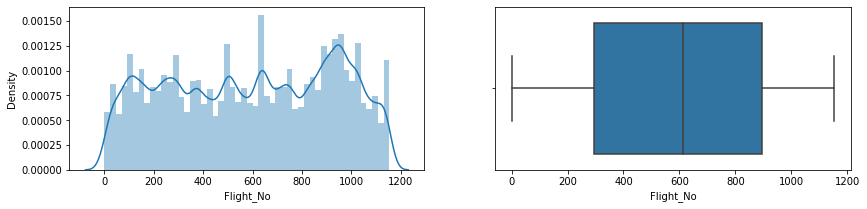

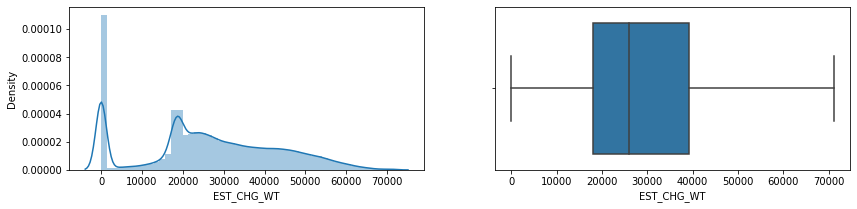

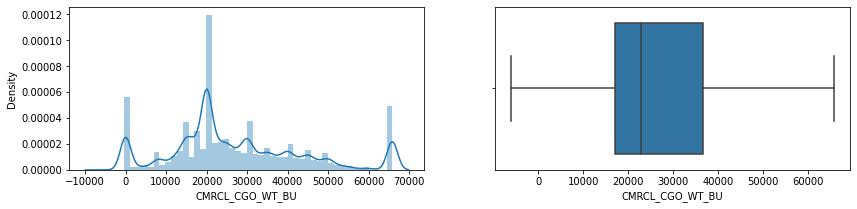

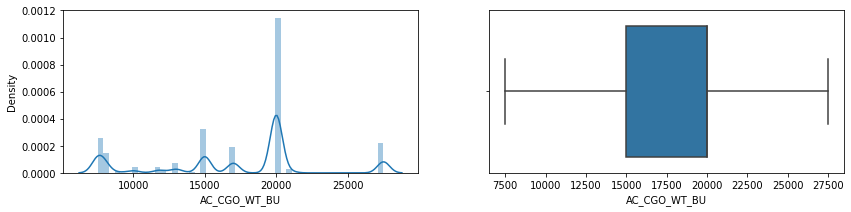

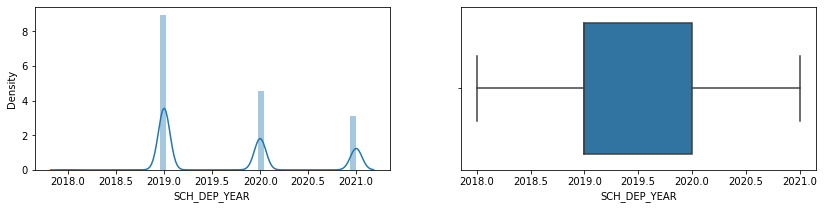

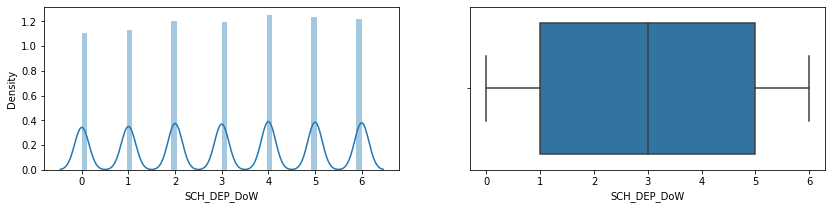

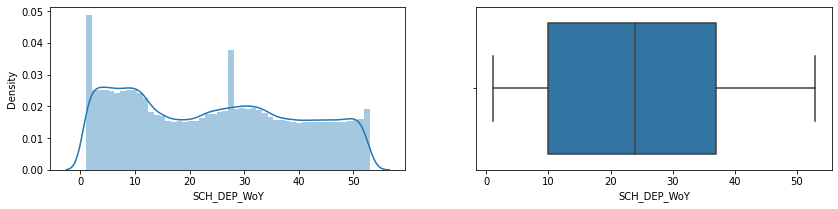

In [61]:
for i in features:
    plt.figure(figsize=(14,3))
    plt.subplot(1,2,1)
    sns.distplot(model_df[i])
    plt.subplot(1,2,2)
    sns.boxplot(model_df[i])

# Feature Selection and Scaling

In [62]:
finalfeatures = ['Flight_No','org','dst','AC_CGO_WT_BU','CMRCL_CGO_WT_BU','EST_CHG_WT','SCH_DEP_YEAR','SCH_DEP_WoY','SCH_DEP_DoW','CHG_WT_BU_sum']
model_df = selectColumns(model_df,finalfeatures)
model_df

,Flight_No,org,dst,AC_CGO_WT_BU,CMRCL_CGO_WT_BU,EST_CHG_WT,SCH_DEP_YEAR,SCH_DEP_WoY,SCH_DEP_DoW,CHG_WT_BU_sum
244554,669,42,99,15000.0,32145.06,34522.966768,2018,1,0,6909.5
192793,40,130,47,20000.0,22932.90,24549.821430,2018,1,0,3632.0
55096,1013,78,47,13000.0,13000.00,28309.559019,2018,1,0,9173.0
143616,484,42,101,15000.0,22509.38,24621.789590,2018,1,0,1294.0
237682,638,5,47,7500.0,0.00,0.000000,2018,1,0,8520.0
...,...,...,...,...,...,...,...,...,...,...
111320,792,98,47,20000.0,20000.00,0.000000,2021,43,5,11.0
206292,541,42,173,7500.0,0.00,0.000000,2021,43,5,2000.0
264614,475,42,149,20000.0,20000.00,0.000000,2021,43,5,667.0
174799,262,98,47,20000.0,20000.00,0.000000,2021,43,5,31.0


In [63]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

ds_x = model_df.drop('CHG_WT_BU_sum',axis =1)
y = model_df['CHG_WT_BU_sum']

dataset = sc.fit_transform(ds_x)
x = pd.DataFrame(dataset,columns=ds_x.columns)

x.head(5)

,Flight_No,org,dst,AC_CGO_WT_BU,CMRCL_CGO_WT_BU,EST_CHG_WT,SCH_DEP_YEAR,SCH_DEP_WoY,SCH_DEP_DoW
0,0.228983,-0.487209,0.726653,-0.392599,0.300957,0.450343,-2.115834,-1.519621,-1.550277
1,-1.667927,1.813713,-0.489135,0.508162,-0.246633,-0.141990,-2.115834,-1.519621,-1.550277
2,1.266403,0.454077,-0.489135,-0.752903,-0.837066,0.081311,-2.115834,-1.519621,-1.550277
3,-0.328932,-0.487209,0.773414,-0.392599,-0.271808,-0.137716,-2.115834,-1.519621,-1.550277
4,0.135495,-1.454642,-0.489135,-1.743739,-1.609813,-1.600072,-2.115834,-1.519621,-1.550277


In [64]:
model_df.skew()

Flight_No         -0.085188
org                1.066519
dst                0.966903
AC_CGO_WT_BU      -0.278636
CMRCL_CGO_WT_BU    0.660796
EST_CHG_WT         0.034338
SCH_DEP_YEAR       0.687231
SCH_DEP_WoY        0.170592
SCH_DEP_DoW       -0.049968
CHG_WT_BU_sum      2.940217
dtype: float64

# XGBoost Modelling and prediction

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [66]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.3, objective='reg:squarederror')

In [67]:
joblib.dump(model,'p_CHG_WT_BU_sum.obj')

['p_CHG_WT_BU_sum.obj']

In [68]:
model = joblib.load('p_CHG_WT_BU_sum.obj')
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)
pred = model.predict(X_test)

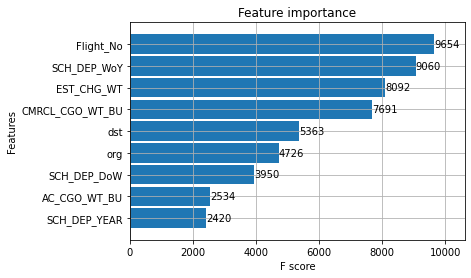

In [69]:
_ = plot_importance(model, height=0.9)

In [70]:
print('R2 Score is ',r2_score(y_test,pred))
print('Mean absolute error is ',mean_absolute_error(y_test,pred))
print('\n')

R2 Score is  0.8751331299061413
Mean absolute error is  3950.948305025909




In [71]:
predicted_values = pd.DataFrame({'Actual':y_test,'Predicted':pred})
predicted_values


,Actual,Predicted
316782,24082.609,26660.742188
206237,92111.030,97776.484375
44655,2576.000,1531.075439
108759,17274.500,12641.334961
198285,22099.000,21562.755859
...,...,...
115560,11355.200,14429.683594
307027,7641.000,13925.742188
332362,2887.400,4839.951172
74767,38595.000,27892.804688


In [72]:
predicted_values['error'] = predicted_values['Actual'] - predicted_values['Predicted']
predicted_values['abs_error'] = predicted_values['error'].apply(np.abs)

predicted_values.head(5)


,Actual,Predicted,error,abs_error
316782,24082.609,26660.742188,-2578.133187,2578.133187
206237,92111.030,97776.484375,-5665.454375,5665.454375
44655,2576.000,1531.075439,1044.924561,1044.924561
108759,17274.500,12641.334961,4633.165039,4633.165039
198285,22099.000,21562.755859,536.244141,536.244141


# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
for i in range(2,9):
    cv = cross_val_score(model,x,y,cv=i)
    print("Cross Validation Score is:",cv.mean())

Cross Validation Score is: 0.7378009732824453
Cross Validation Score is: 0.7434281732227842
